<a href="https://colab.research.google.com/github/jonsarz16/SpeechEmoRec/blob/main/SpeechEmotionRecognitionStreamlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Required Packages**

In [ ]:
# Python
import os
import numpy as np
import librosa, librosa.display
import pandas as pd
import IPython.display as ipd
from matplotlib import pyplot as plt

import math
import scipy
import random
from random import randrange, uniform

from tensorflow.python.framework import dtypes
!pip install tensorflow_io
import cv2
import tensorflow as tf
import tensorflow_io as tfio

     |████████████████████████████████| 23.1 MB 1.4 MB/s 
     |████████████████████████████████| 2.1 MB 62.6 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.22.0
    Uninstalling tensorflow-io-gcs-filesystem-0.22.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.22.0


**Mount Google Drive to connect dataset to colab**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


**Reading the data**

In [ ]:
# Data Directory
dir_list = os.listdir('/content/gdrive/My Drive/TESS')
# dir_list = os.listdir('TESS')
dir_list.sort()
print (dir_list)

['OAF_Fear', 'OAF_Pleasant_surprise', 'OAF_Sad', 'OAF_angry', 'OAF_disgust', 'OAF_happy', 'OAF_neutral', 'Spectrogram', 'YAF_angry', 'YAF_disgust', 'YAF_fear', 'YAF_happy', 'YAF_neutral', 'YAF_pleasant_surprised', 'YAF_sad']


In [ ]:
# Create DataFrame
speech_df = pd.DataFrame(columns=['file_path', 'actress', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('/content/gdrive/My Drive/TESS/' + i)
    # file_list = os.listdir('TESS/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        file_path = '/content/gdrive/My Drive/TESS/' + i + '/' + f
        # file_path = 'TESS/' + i + '/' + f
        emotions = ["angry", "sad", "neutral", "happy", "fear", "disgust", "surprise"]

        if "OAF" in file_path:
            actress = "old"
        else:
            actress = "young"

        for x in emotions:   
            if x in file_path:
                emotion = x
            
        speech_df.loc[count] = [file_path, actress, emotion]
        count += 1

In [ ]:
print (len(speech_df)) #number of audio files in the dataset
speech_df #print

2803


,file_path,actress,emotion
0,/content/gdrive/My Drive/TESS/OAF_Fear/OAF_bac...,old,fear
1,/content/gdrive/My Drive/TESS/OAF_Fear/OAF_bar...,old,fear
2,/content/gdrive/My Drive/TESS/OAF_Fear/OAF_bur...,old,fear
3,/content/gdrive/My Drive/TESS/OAF_Fear/OAF_bou...,old,fear
4,/content/gdrive/My Drive/TESS/OAF_Fear/OAF_boo...,old,fear
...,...,...,...
2798,/content/gdrive/My Drive/TESS/YAF_sad/YAF_rais...,young,sad
2799,/content/gdrive/My Drive/TESS/YAF_sad/YAF_thum...,young,sad
2800,/content/gdrive/My Drive/TESS/YAF_sad/YAF_shee...,young,sad
2801,/content/gdrive/My Drive/TESS/YAF_sad/YAF_wash...,young,sad


In [ ]:
grouped_data = speech_df.groupby("emotion").count()[['file_path']]
grouped_data.rename(columns={'file_path':'Files'})

,Files
emotion,
angry,400
disgust,400
fear,400
happy,400
neutral,403
sad,400
surprise,400


In [ ]:
for column in speech_df[['file_path']]:
   path = speech_df[column]
   file_name = path.values
   print(file_name)

['TESS/OAF_Fear/OAF_back_fear.wav' 'TESS/OAF_Fear/OAF_bar_fear.wav'
 'TESS/OAF_Fear/OAF_burn_fear.wav' ... 'TESS/YAF_sad/YAF_sheep_sad.wav'
 'TESS/YAF_sad/YAF_wash_sad.wav' 'TESS/YAF_sad/YAF_pike_sad.wav']


In [ ]:
def createWaveplot(sample, sr, e, a):
  plt.figure()
  librosa.display.waveplot(sample, sr)
  plt.title("Waveplot for audio with {} emotion ({} voice)".format(e,a))
  plt.xlabel("Time (seconds)")
  plt.ylabel("Amplitude")
  plt.show()

In [ ]:
emotion = "fear"
actress = "old"
filepath = np.array(speech_df.file_path[np.logical_and(speech_df.emotion==emotion, speech_df.actress==actress)])[0] 
sample, srate = librosa.load(filepath) 
ipd.Audio(sample, rate=srate)

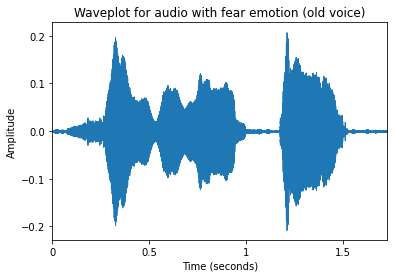

In [ ]:
#### -------------start of data visualization --------------
createWaveplot(sample,srate,emotion, actress)

In [ ]:
emotion = "angry"
actress = "young"
filepath = np.array(speech_df.file_path[np.logical_and(speech_df.emotion==emotion, speech_df.actress==actress)])[122] 
sample, srate = librosa.load(filepath) 
ipd.Audio(sample, rate=srate)

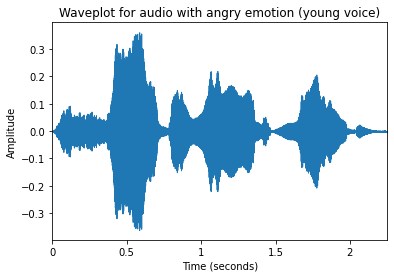

In [ ]:
createWaveplot(sample,srate,emotion,actress)

**Augmentation Methods**

In [ ]:
def time_mask(spec, no_of_mask, mask_size):
  i = 1

  while i <= no_of_mask:
    time_masked = tfio.audio.freq_mask(spec, param=mask_size)
    spec = time_masked
    mask_size = randrange(8, 12)
    i += 1
  return time_masked.numpy()

def freq_mask(spec, no_of_mask, mask_size):
  i = 1
  while i <= no_of_mask:
    freq_masked = tfio.audio.time_mask(spec, param=mask_size)
    spec = freq_masked #set the new modified array to the original variable
    mask_size = randrange(8, 12)
    i += 1
  return freq_masked.numpy()

def tempo(data, rate): #0.8
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate, pitch_pm):
    """
    Pitch Tuning.
    """
    bins_per_octave = 15
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data

In [ ]:
ipd.Audio(tempo(sample, 0.3), rate=srate)

**Audio Pre-processing/Visualization** 

In [ ]:
# Convert audio signal to Spectrogram (STFT uses a sliding-frame FFT to produce a 2D matrix) 
#source: https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53

FIG_SIZE = (10,5)
hop_length = 512 #stride
n_fft = 2048 #num. of samples per window

In [ ]:
# Perform STFT to retrieve features from the audio files
stft = librosa.stft(sample, n_fft=n_fft, hop_length=hop_length)
stft

array([[-2.6849795e-02+0.00000000e+00j, -4.1169997e-02+0.00000000e+00j,
        -9.5761502e-03+0.00000000e+00j, ...,
         5.4814108e-02+0.00000000e+00j,  3.2511447e-03+0.00000000e+00j,
         7.8337371e-02+0.00000000e+00j],
       [-3.1983376e-02+2.80537312e-18j,  5.9331618e-02-1.66307725e-02j,
        -2.6764268e-02+5.22691086e-02j, ...,
        -1.7118187e-01-9.93291810e-02j,  1.5481301e-01+3.91290858e-02j,
        -1.8012448e-01+3.89005542e-02j],
       [ 4.2054959e-02-2.59496352e-17j, -7.0256449e-02+4.50843535e-02j,
         4.3991584e-02-5.20706549e-02j, ...,
         1.6667461e-01+1.71496779e-01j, -2.3322415e-01-1.14558237e-02j,
         2.9282901e-01-4.31041457e-02j],
       ...,
       [ 3.0826032e-04+1.88034759e-18j, -4.3810889e-04+8.32089863e-05j,
         6.8087556e-04+5.01745206e-04j, ...,
         2.9670387e-06+9.48653542e-06j, -3.0969811e-06-8.90449974e-06j,
        -1.1313751e-05+6.01970305e-06j],
       [-8.5736894e-05+1.73743398e-17j,  1.5981959e-05-4.72404470e-0

In [ ]:
# Calculate the Magnitude (absolute values on complex numbers)
spectrogram = np.abs(stft)

Text(0.5, 1.0, 'Spectrogram')

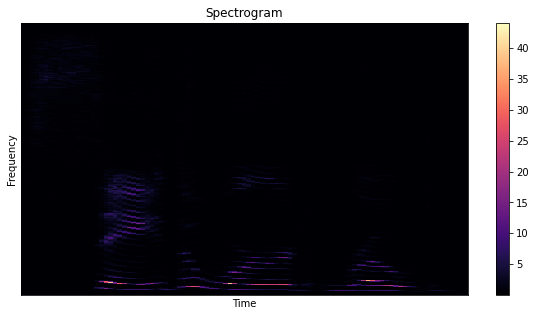

In [ ]:
# Plot the Spectrogram (standard spectrogram)
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=srate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

In [ ]:
# Spectrogram to wav
def spsi(msgram, fftsize, hop_length) :
    """
    Takes a 2D spectrogram ([freqs,frames]), the fft legnth (= widnow length) and the hope size (both in units of samples).
    Returns an audio signal.
    """
    
    numBins, numFrames  = msgram.shape
    y_out=np.zeros(numFrames*hop_length+fftsize-hop_length)
        
    m_phase=np.zeros(numBins);      
    m_win=scipy.signal.hanning(fftsize, sym=True)  # assumption here that hann was used to create the frames of the spectrogram
    
    #processes one frame of audio at a time
    for i in range(numFrames) :
            m_mag=msgram[:, i] 
            for j in range(1,numBins-1) : 
                if(m_mag[j]>m_mag[j-1] and m_mag[j]>m_mag[j+1]) : #if j is a peak
                    alpha=m_mag[j-1]
                    beta=m_mag[j]
                    gamma=m_mag[j+1]
                    denom=alpha-2*beta+gamma
                    
                    if(denom!=0) :
                        p=0.5*(alpha-gamma)/denom
                    else :
                        p=0
                        
                    #phaseRate=2*math.pi*(j-1+p)/fftsize;    #adjusted phase rate
                    phaseRate=2*math.pi*(j+p)/fftsize;    #adjusted phase rate
                    m_phase[j]= m_phase[j] + hop_length*phaseRate; #phase accumulator for this peak bin
                    peakPhase=m_phase[j]
                    
                    # If actual peak is to the right of the bin freq
                    if (p>0) :
                        # First bin to right has pi shift
                        bin=j+1
                        m_phase[bin]=peakPhase+math.pi
                        
                        # Bins to left have shift of pi
                        bin=j-1
                        while((bin>1) and (m_mag[bin]<m_mag[bin+1])) : # until you reach the trough
                            m_phase[bin]=peakPhase+math.pi
                            bin=bin-1
                        
                        #Bins to the right (beyond the first) have 0 shift
                        bin=j+2
                        while((bin<(numBins)) and (m_mag[bin]<m_mag[bin-1])) :
                            m_phase[bin]=peakPhase
                            bin=bin+1
                            
                    #if actual peak is to the left of the bin frequency
                    if(p<0) :
                        # First bin to left has pi shift
                        bin=j-1
                        m_phase[bin]=peakPhase+math.pi

                        # and bins to the right of me - here I am stuck in the middle with you
                        bin=j+1
                        while((bin<(numBins)) and (m_mag[bin]<m_mag[bin-1])) :
                            m_phase[bin]=peakPhase+math.pi
                            bin=bin+1
                        
                        # and further to the left have zero shift
                        bin=j-2
                        while((bin>1) and (m_mag[bin]<m_mag[bin+1])) : # until trough
                            m_phase[bin]=peakPhase
                            bin=bin-1
                            
                #end ops for peaks
            #end loop over fft bins with

            magphase=m_mag*np.exp(1j*m_phase)  #reconstruct with new phase (elementwise mult)
            magphase[0]=0; magphase[numBins-1] = 0 #remove dc and nyquist
            m_recon=np.concatenate([magphase,np.flip(np.conjugate(magphase[1:numBins-1]), 0)]) 
            
            #overlap and add
            m_recon=np.real(np.fft.ifft(m_recon))*m_win
            y_out[i*hop_length:i*hop_length+fftsize]+=m_recon
            
    return y_out

In [ ]:
y_out = spsi(spectrogram, fftsize=n_fft, hop_length=hop_length)
ipd.Audio(data=y_out, rate=srate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  if sys.path[0] == '':


**The y-axis is converted to a log scale, and the color dimension is converted to decibels**



Text(0.5, 1.0, 'Spectrogram')

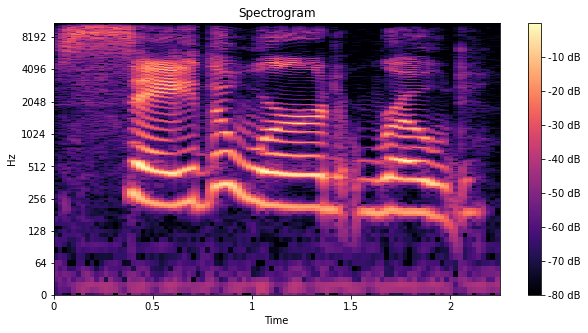

In [ ]:
spec = librosa.amplitude_to_db(spectrogram, ref=np.max)
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spec, sr=srate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

**Create Mel Spectrogram by converting frequencies to mel-scale**

In [ ]:
def create_melspectrogram(sample, srate, actress, emotion, index):
  mel_spectrogram = librosa.feature.melspectrogram(sample, sr=srate, n_fft=2048, hop_length=128, n_mels=256)
  mel_spect = librosa.power_to_db(mel_spectrogram, ref=np.max)  #power_to_db = amplitude squared to decibel units

  return mel_spect.shape
  # plt.figure(figsize=FIG_SIZE)
  # librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
  # plt.title('Mel Spectrogram');
  # plt.title('Mel Spectrogram '+ str(index) + ": " + lbl_actress + " || " + lbl_emotion)
  # plt.colorbar(format='%+2.0f dB');
  # plt.show()

**Converting TESS to Mel Spectrogram**


In [ ]:
#loop inside dataframe (per tuple)
for row in (speech_df[2:3].itertuples()): #row[0] = index number(0 to 2800) row[1] = path  row[2] = actress  row[3] = emotion
  lbl_emotion = row[3]
  lbl_actress = row[2]
  index = row[0]

  sample, srate = librosa.load(row[1])
  p = create_melspectrogram(sample, srate, lbl_actress, lbl_emotion, index)
  print(p)

  ####-------end of data visualization-----------

(256, 251)


**Convert audio to mel-spectrogram and save its equivalent 2D array to google drive in .json format**

In [ ]:
import json
from json import JSONEncoder

#serialize the NumPy Array into JSON String meaning convert mel_spect 2D array to a json format
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [ ]:
#Create directory for....
save_path = '/content/gdrive/My Drive/Mel Spectrogram/'
# save_path = '/Mel Spectrogram/'
# Check whether the specified path exists or not
isExist = os.path.exists(save_path)

if not isExist:
  # Create a new directory if does not exist 
  os.makedirs(save_path)

In [ ]:
#image file name
def fn_label(emotion, actress):
  emotions = {
      "angry": "01",
      "disgust": "02",
      "fear": "03",
      "happy": "04",
      "neutral": "05",
      "sad": "06",
      "surprise": "07"
  }

  if actress == 'young':
    act = 'Y'
  else:
    act = 'O'

  return emotions[emotion]+"_"+act

In [ ]:
# def padding(array, desired_height, desired_width):

#     h = array.shape[0]
#     w = array.shape[1]

#     a = (desired_height - h) // 2
#     aa = desired_height - a - h

#     b = (desired_width - w) // 2
#     bb = desired_width - b - w

#     return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [ ]:
# def res (mel_spect):
#   arr_2d = np.zeros((256, 256) , dtype=np.float64)
#   num_rows, num_cols = mel_spect.shape
#   x, y = arr_2d.shape
#   for j in range(x):
#     for l in range(y):
#       arr_2d[j,l] = -80

#   if sh != (256,256):
#     for i in range(num_rows):
#       for k in range(num_cols):
#         arr_2d[i,k] = mel_spect[i, k]
#         mel_spect = np.resize(mel_spect, (256, 256))
  
#   return mel_spect

In [ ]:
#Convert audio to mel spectrogram, divide dataset 70% - training and 30% - testing, temporarily saved equivalent 2D array (256x256) to a python dictionary

#for testing only
batch = 20  #batch row size
list_df = [speech_df[0:100] for i in range(0,speech_df[0:100].shape[0],batch)] #for testing only
random_int = random.sample(range(0,99), 30)

train_dict = dict()
test_dict = dict()

#final code for batch conversion
# batch = 200
# list_df = [speech_df[i:i+batch] for i in range(0,speech_df.shape[0],batch)] #convert all
# random_int = random.sample(range(0,199), 60) #generate list of [60] random integers for random selection

for chunk in list_df:
  counter = 0 
  for row in (chunk.sample(frac=1).itertuples()): #row[0] = index number(0 to 2800) row[1] = path  row[2] = actress  row[3] = emotion .sample(frac1) = shuffles dataframe rows
    lbl_emotion = row[3]
    lbl_actress = row[2]
    file_audio = row[1]
    index = row[0]

    sample, srate = librosa.load(file_audio)
    mel_spectrogram = librosa.feature.melspectrogram(sample, sr=srate, n_fft=n_fft, hop_length=hop_length, n_mels=256)
    mel_spect = librosa.power_to_db(mel_spectrogram, ref=np.max)  #power_to_db = amplitude squared to decibel units
    format_file_name = fn_label(lbl_emotion, lbl_actress)+ str(counter)

    #tempo scaling
    rand_tempo_rate = random.choice([0.5, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5])
    augment_tempo_sample = (tempo(sample,rand_tempo_rate))
    a_mel_spectrogram = librosa.feature.melspectrogram(augment_tempo_sample, sr=srate, n_fft=n_fft, hop_length=hop_length, n_mels=256)
    a_mel_spect = librosa.power_to_db(a_mel_spectrogram, ref=np.max)  #power_to_db = amplitude squared to decibel units

    #pitch scaling
    rand_pitch_pm = random.choice([-3, -2, -1, 2, 4, 6, 8, 10])
    augment_pitch_sample = (pitch(sample,srate, rand_pitch_pm))
    b_mel_spectrogram = librosa.feature.melspectrogram(augment_pitch_sample, sr=srate, n_fft=n_fft, hop_length=hop_length, n_mels=256)
    b_mel_spect = librosa.power_to_db(b_mel_spectrogram, ref=np.max)  #power_to_db = amplitude squared to decibel units

    mel_spect1 = cv2.resize(mel_spect, (256, 256)) 
    a_mel_spect = cv2.resize(a_mel_spect, (256, 256)) 
    b_mel_spect = cv2.resize(b_mel_spect, (256, 256)) 

    #Serialization
    # mel_spect = {"array": mel_spect1}
    # a_mel_spect = {"array": a_mel_spect}
    # b_mel_spect = {"array": b_mel_spect}
    #encodedNumpyData = json.dumps(numpyData, cls=NumpyArrayEncoder)
    
    #sh = mel_spect.shape
    rand_int = randrange(1, 4)
    mask_size = randrange(8,12)

    #  if sh != (256,256):
    #   mel_spect = padding(mel_spect, 256, 256)
    #   a_mel_spect = padding(a_mel_spect, 256, 256)
    #   b_mel_spect = padding(b_mel_spect, 256, 256)

    #if counter in random_int:
      #test_dict[format_file_name] = encodedNumpyData
      # freq_masked = freq_mask(mel_spect1, rand_int, mask_size)
      # time_masked = time_mask(mel_spect1, rand_int, mask_size)
      # test_dict[format_file_name] = json.dumps(mel_spect, cls=NumpyArrayEncoder)
      # test_dict[format_file_name + "F"] = json.dumps(cv2.resize(freq_masked, (256, 256)), cls=NumpyArrayEncoder)
      # test_dict[format_file_name + "T"] = json.dumps(cv2.resize(time_masked, (256, 256)), cls=NumpyArrayEncoder)
      # test_dict[format_file_name + "TP"] = json.dumps(a_mel_spect, cls=NumpyArrayEncoder)
      # test_dict[format_file_name + "P"] = json.dumps(b_mel_spect, cls=NumpyArrayEncoder)

    #else:
      #train_dict[format_file_name] = encodedNumpyData
      # freq_masked = freq_mask(mel_spect1, rand_int, mask_size)
      # time_masked = time_mask(mel_spect1, rand_int, mask_size)
      # train_dict[format_file_name] = json.dumps(mel_spect, cls=NumpyArrayEncoder)
      # train_dict[format_file_name + "F"] = json.dumps(cv2.resize(freq_masked, (256, 256)), cls=NumpyArrayEncoder)
      # train_dict[format_file_name + "T"] = json.dumps(cv2.resize(time_masked, (256, 256)), cls=NumpyArrayEncoder)
      # train_dict[format_file_name + "TP"] = json.dumps(a_mel_spect, cls=NumpyArrayEncoder)
      # train_dict[format_file_name + "P"] = json.dumps(b_mel_spect, cls=NumpyArrayEncoder)

    if counter in random_int:
      #test_dict[format_file_name] = encodedNumpyData
      freq_masked = freq_mask(mel_spect, rand_int, mask_size)
      time_masked = time_mask(mel_spect, rand_int, mask_size)
      test_dict[format_file_name] = mel_spect1
      test_dict[format_file_name + "F"] = cv2.resize(freq_masked, (256, 256))
      test_dict[format_file_name + "T"] = cv2.resize(time_masked, (256, 256))
      test_dict[format_file_name + "TP"] = a_mel_spect
      test_dict[format_file_name + "P"] = b_mel_spect

    else:
      #train_dict[format_file_name] = encodedNumpyData
      freq_masked = freq_mask(mel_spect, rand_int, mask_size)
      time_masked = time_mask(mel_spect, rand_int, mask_size)
      train_dict[format_file_name] = mel_spect1
      train_dict[format_file_name + "F"] = cv2.resize(freq_masked, (256, 256))
      train_dict[format_file_name + "T"] = cv2.resize(time_masked, (256, 256))
      train_dict[format_file_name + "TP"] = a_mel_spect
      train_dict[format_file_name + "P"] = b_mel_spect
      
    counter += 1

In [ ]:
with open(f"{save_path}/" + 'test_spect.json', 'w') as outfile:
    json.dump(test_dict, outfile)

with open(f"{save_path}/" + 'train_spect.json', 'w') as outfile:
    json.dump(train_dict, outfile)

TypeError: ignored

In [ ]:
print(train_dict.keys())

dict_keys(['03_O1', '03_O1F', '03_O1T', '03_O1TP', '03_O1P', '03_O2', '03_O2F', '03_O2T', '03_O2TP', '03_O2P', '03_O3', '03_O3F', '03_O3T', '03_O3TP', '03_O3P', '03_O4', '03_O4F', '03_O4T', '03_O4TP', '03_O4P', '03_O6', '03_O6F', '03_O6T', '03_O6TP', '03_O6P', '03_O7', '03_O7F', '03_O7T', '03_O7TP', '03_O7P', '03_O8', '03_O8F', '03_O8T', '03_O8TP', '03_O8P', '03_O10', '03_O10F', '03_O10T', '03_O10TP', '03_O10P', '03_O12', '03_O12F', '03_O12T', '03_O12TP', '03_O12P', '03_O13', '03_O13F', '03_O13T', '03_O13TP', '03_O13P', '03_O14', '03_O14F', '03_O14T', '03_O14TP', '03_O14P', '03_O15', '03_O15F', '03_O15T', '03_O15TP', '03_O15P', '03_O18', '03_O18F', '03_O18T', '03_O18TP', '03_O18P', '03_O22', '03_O22F', '03_O22T', '03_O22TP', '03_O22P', '03_O23', '03_O23F', '03_O23T', '03_O23TP', '03_O23P', '03_O25', '03_O25F', '03_O25T', '03_O25TP', '03_O25P', '03_O26', '03_O26F', '03_O26T', '03_O26TP', '03_O26P', '03_O27', '03_O27F', '03_O27T', '03_O27TP', '03_O27P', '03_O28', '03_O28F', '03_O28T', '0

In [ ]:
# print(train_dict.get('03_O2').shape)

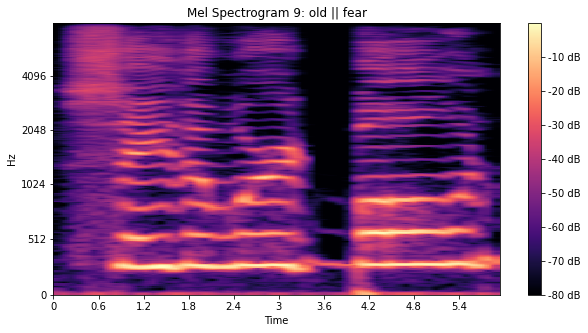

In [ ]:

# with np.printoptions(threshold=np.inf): #print the whole array
#   print(test_dict.get('03_O0F'))

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(train_dict.get('03_O1'), y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.title('Mel Spectrogram '+ str(index) + ": " + lbl_actress + " || " + lbl_emotion )
plt.colorbar(format='%+2.0f dB');
plt.show()


**Training Data**

In [ ]:
FIG_SIZE = (10,5)
def first2char(spec_img_name): #function to get the first 2 characters of the key of each value in the dictionary
  return spec_img_name[:2]

def spec_label_emo (spec_label):
  switch={
    '01':'angry',
    '02':'disgust',
    '03':'fear',
    '04':'happy',
    '05':'neutral',
    '06':'sad',
    '07':'surprise'
  }
  return switch.get(spec_label,"Invalid input")

# def create_df (dictionary):  #create dataframe from the dictionary
#   df = pd.DataFrame(columns=['spectrogram_key', 'actress', 'emotion'])
#   count = 0

#   for spectrogram_key in dictionary.keys():
#     emotion = spec_label_emo(first2char(spectrogram_key))
#     filename = spectrogram_key

#     if "Y" in spectrogram_key:
#       actress = "young"
#     else:
#       actress = "old"
              
#     df.loc[count] = [filename, actress, emotion]
#     count += 1

#   return df

def create_dataframe (dictionary):  #create dataframe from the dictionary
  df = pd.DataFrame(columns=['MelSpectrogram', 'emotion'])
  count = 0

  for spectrogram_key in dictionary.keys():
    emotion = first2char(spectrogram_key)
    
    MelSpectrogram = dictionary.get(spectrogram_key)
    
    df.loc[count] = [MelSpectrogram, emotion]
    count += 1

  return df

def create_grouped_df(df):  #summarize the data in the dataframe
  group_df = df.groupby(['emotion', 'actress']).agg(emotion = ('actress', 'count'))
  df = group_df.rename(columns={'emotion':'Total #'},inplace=False)
  #df = pd.crosstab(df_train.emotion,df_train.actress) #alternate
  return df


In [ ]:
#train dataframe
label = 'Total # of training data'
print (label + ': ' + str(len(create_dataframe(train_dict)))) #number of audio files in the dataset
train_df = create_dataframe(train_dict) #print
train_df.head()


In [ ]:
Y_train = train_df.emotion  #label
X_train = train_df.drop('emotion',axis=1) #feature


Y_train = Y_train.astype("float")

train_x = X_train['MelSpectrogram'].values.tolist()
X_train = np.asarray(train_x, dtype=np.float64)

X_train = np.array(X_train)
# X_train = np.abs(np.array(X_train))
Y_train = np.array(Y_train)



**Testing Data**

In [ ]:
# test dataframe
label = 'Total # of testing data'
print (label + ': ' + str(len(create_dataframe(test_dict)))) #number of audio files in the dataset
test_df = create_dataframe(test_dict) #print
test_df.head()

Total # of testing data: 150


In [ ]:
Y_test = test_df.emotion  #label
X_test = test_df.drop('emotion', axis=1) #feature data

Y_test = Y_test.astype("float")

#print(X_test['MelSpectrogram'][1].shape)
test_x = X_test['MelSpectrogram'].values.tolist()
X_test = np.asarray(test_x, dtype=np.float64)

# X_test = np.abs(np.array(X_test))
X_test = np.array(X_test)
Y_test = np.array(Y_test)


**BASELINE ALGO**

In [ ]:
#link: https://gist.github.com/MuhammadArdiPutra/0079188c37caa21c6b7c3e86d41fcd59/
#link: https://github.com/rosariomoscato/Rosario-Moscato-Lab/blob/main/Audio/Music_Genre_Classification_2.ipynb
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential, load_model
import tensorflow.keras as keras
from sklearn.preprocessing import OneHotEncoder

# Value normalization
# X_train  = X_train/255
# X_test  = X_test/255

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
#Building DSCNN model
model = Sequential()

#1st convolution layer
model.add(Conv2D(32, 11, activation='relu', strides=(2, 2), padding='same', input_shape=input_shape))
model.add(BatchNormalization())

#2nd convolution layer
model.add(Conv2D(64, 7, activation='relu', strides=(2, 2), padding='same'))
model.add(BatchNormalization())

#3rd convolution layer
model.add(Conv2D(128, 5, activation='relu', strides=(2, 2), padding='same'))
model.add(BatchNormalization())

#4th convolution layer
model.add(Conv2D(128, 5, activation='relu', strides=(2, 2), padding='same'))
model.add(BatchNormalization())

#5th convolution layer
model.add(Conv2D(256, 5, activation='relu', strides=(2, 2), padding='same'))
model.add(BatchNormalization())

#flatten layer
model.add(Flatten())

#1st fully connected layer
model.add(Dense(512, activation='relu'))

#2nd fully connected layer
model.add(Dense(1024, activation='relu'))

#dropput layer
model.add(Dropout(0.5))

#output/classification layer
model.add(Dense(7, activation='softmax'))

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      3904      
                                                                 
 batch_normalization_10 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        100416    
                                                                 
 batch_normalization_11 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 128)       204928    
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 128)     

In [ ]:
#train model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=50)
#history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/50
11/11 [==============================] - 54s 5s/step - loss: 0.2678 - accuracy: 0.9057 - val_loss: 0.1099 - val_accuracy: 1.0000
Epoch 2/50


KeyboardInterrupt: ignored

In [ ]:
file_model = model.save('model/my_model.hdf5')

print(file_model)

In [ ]:
#convert dictionary to .json format and save .json file to google drive
# with open(f"{save_path}/" + 'test_spec_data.json', 'w') as outfile:
#     json.dump(test_dict, outfile)

# with open(f"{save_path}/" + 'train_spec_data.json', 'w') as outfile:
#     json.dump(train_dict, outfile)

In [ ]:
#Create directory for....
#train_save_path = '/content/gdrive/My Drive/Mel Spectrogram/Train' ##new directory for spectrogram images 70%
#test_save_path = '/content/gdrive/My Drive/Mel Spectrogram/Test' ##new directory for spectrogram images 30%

# Check whether the specified path exists or not
#train_isExist = os.path.exists(train_save_path)
#test_isExist = os.path.exists(test_save_path) 

#if not train_isExist:
  # Create a new directory if does not exist 
 # os.makedirs(train_save_path)

#if not test_isExist:
  # Create a new directory if does not exist 
 # os.makedirs(test_save_path)
  

In [ ]:
#Convert audio to mel spectrogram and save to a separate google drive folder
#21 minutes and 2 seconds

#for testing only
# batch = 2  #batch row size
# list_df = [speech_df[0:10] for i in range(0,speech_df[0:10].shape[0],batch)] #for testing only

#final code for batch conversion
#batch = 200
#list_df = [speech_df[i:i+batch] for i in range(0,speech_df.shape[0],batch)] #convert all

#random_list = random.sample(range(0, batch), #30% of the batch size)

#for chunk in list_df:
#  counter = 0
#  random_int = random.sample(range(0,199), 60) #generate list of [three] random integers for random selection
#  for row in (chunk.sample(frac=1).itertuples()): #row[0] = index number(0 to 2800) row[1] = path  row[2] = actress  row[3] = emotion .sample(frac1) = shuffles dataframe rows
#    lbl_emotion = row[3]
#    lbl_actress = row[2]
#    file_audio = row[1]
#    index = row[0]
    
#    sample, srate = librosa.load(file_audio)
#    mel_spectrogram = librosa.feature.melspectrogram(sample, sr=srate, n_fft=n_fft, hop_length=hop_length, n_mels=128)
#    mel_spect = librosa.power_to_db(mel_spectrogram, ref=np.max)  #power_to_db = amplitude squared to decibel units
#    plt.figure(figsize=FIG_SIZE)
#    librosa.display.specshow(mel_spect,fmax=8000);
#    format_file_name = fn_label(lbl_emotion, lbl_actress)+ str(index) +'.png'
#    
#    if counter in random_int:
#      plt.savefig(f"{test_save_path}/"+ format_file_name,transparent=True,bbox_inches='tight',pad_inches=0, dpi=256);  #saving images to a separate folder 'Mel Spectrogram/Test' in gdrive
#      plt.close()
#    else:
#      plt.savefig(f"{train_save_path}/"+ format_file_name,transparent=True,bbox_inches='tight',pad_inches=0, dpi=256);  #saving images to a separate folder 'Mel Spectrogram/Train' in gdrive
#      plt.close() 

#    counter += 1

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/model/my_model.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Speech Emotion Recognition
         """
         )

audiofile = st.file_uploader("Please upload audio file", type=["wav", "mp3"])
if audio_file is not None:
  if not os.path.exists("audio"):
    os.makedirs("audio")
  uploaded_audio = os.path.join("audio", audio_file.name)
  #path
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)


def import_and_predict(image_data, model):
    
        size = (180,180)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction


if file is None:
    st.text("Please upload an audio file")
else:
    audio_file = open(uploaded_audio, ‘rb’)
    audio_bytes = audio_file.read()
    st.audio(audio_bytes, format=‘audio/ogg’,start_time=0)
    predictions = import_and_predict(image, model)#image var replace with preprocess data
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

